In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
os.chdir('/home/tapas/')

In [6]:
data = pd.read_csv('cs-training.csv').drop('Unnamed: 0', axis = 1)

In [7]:
cleanCol = []
for i in range(len(data.columns)):
    cleanCol.append(data.columns[i].replace('-', ''))
    
data.columns = cleanCol

In [8]:
def removeSpecificAndPutMedian(data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val)
            
    return New

In [9]:
def add_freq():
    ncount = len(data)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

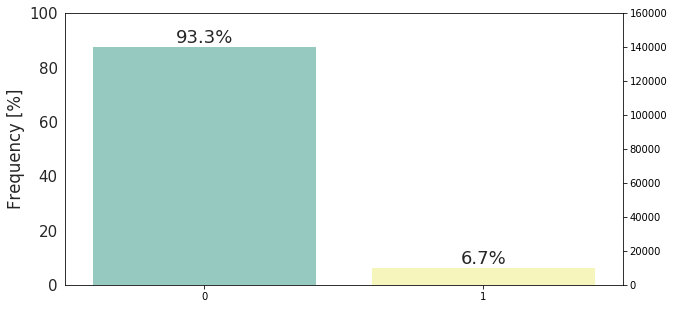

In [10]:
ax = sns.countplot(x = data.SeriousDlqin2yrs ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

add_freq()

plt.show()

In [11]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))


def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = zip(data.index, x, y, z)
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        tfOutlier = zip(x, func(x))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(zip(data, vote), columns=['debt', 'outlier'])
    if replace == 'median':
        replace = x.debt.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in zip(data, vote) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            debtNew.append(replace)
        else:
            debtNew.append(x.iloc[i][0])
    
    return debtNew

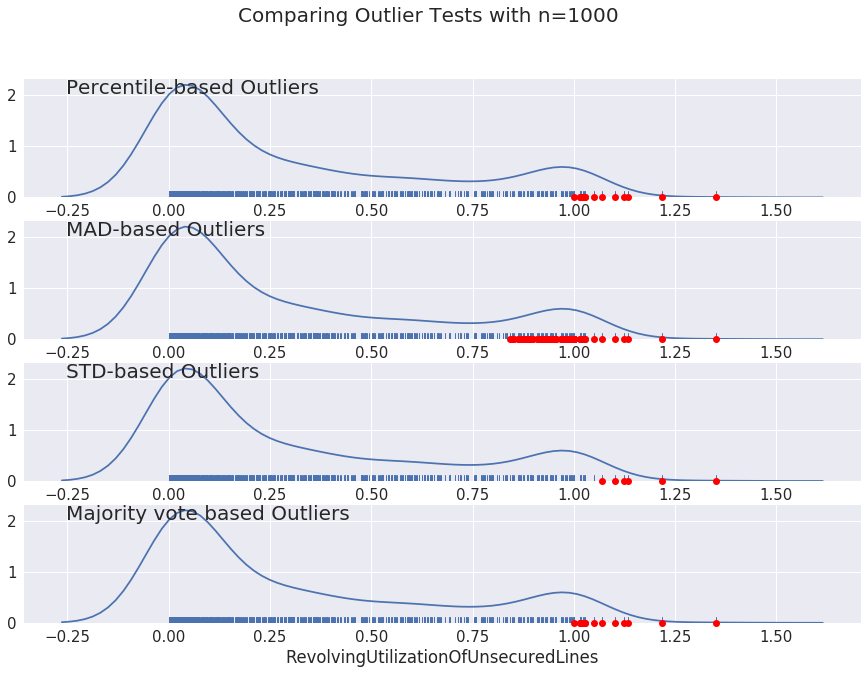

In [12]:
plotOutlier(data.RevolvingUtilizationOfUnsecuredLines.sample(1000))

In [1]:
revNew = []
for val in data.RevolvingUtilizationOfUnsecuredLines:
    if val <= 2:
        revNew.append(val)
    else:
        revNew.append(2.)

NameError: name 'data' is not defined

In [ ]:
data.RevolvingUtilizationOfUnsecuredLines = revNew

In [ ]:
data.age.plot.box()

In [ ]:
for i in range(16,30):
    print i, len(data[data.age < i])

In [ ]:
ageNew = []
for val in data.age:
    if val > 22:
        ageNew.append(val)
    else:
        ageNew.append(22)
        
data.age = ageNew

In [ ]:
Counter(data.NumberOfTime3059DaysPastDueNotWorse)

In [ ]:
New = []
med = data.NumberOfTime3059DaysPastDueNotWorse.median()
for val in data.NumberOfTime3059DaysPastDueNotWorse:
    if ((val == 98) | (val == 96)):
        New.append(med)
    else:
        New.append(val)

data.NumberOfTime3059DaysPastDueNotWorse = New

In [ ]:
outlierRatio(data.DebtRatio)

In [ ]:
plotOutlier(data.DebtRatio.sample(1000))

In [ ]:
ax = sns.countplot(mad_based_outlier(data.DebtRatio))
add_freq()

In [ ]:
minUpperBound = min([val for (val, out) in zip(data.DebtRatio, mad_based_outlier(data.DebtRatio)) if out == True])

In [ ]:
newDebtRatio = []
for val in data.DebtRatio:
    if val > minUpperBound:
        newDebtRatio.append(minUpperBound)
    else:
        newDebtRatio.append(val)

In [ ]:
data.DebtRatio = newDebtRatio

In [ ]:
data.DebtRatio.describe()

In [ ]:
plotOutlier(data.MonthlyIncome.sample(1000))

In [ ]:
plotOutlierFree(data.MonthlyIncome.sample(1000))

In [ ]:
incomeNew = replaceOutlier(data.MonthlyIncome, replace='minUpper')

In [ ]:
data.MonthlyIncome = incomeNew

In [ ]:
new = removeSpecificAndPutMedian(data.NumberOfTimes90DaysLate)

In [ ]:
data.NumberOfTimes90DaysLate = new

In [ ]:
realNew = []
for val in data.NumberRealEstateLoansOrLines:
    if val > 17:
        realNew.append(17)
    else:
        realNew.append(val)

In [ ]:
data.NumberRealEstateLoansOrLines = realNew

In [ ]:
new = removeSpecificAndPutMedian(data.NumberOfTime6089DaysPastDueNotWorse)

In [ ]:
data.NumberOfTime6089DaysPastDueNotWorse = new

In [ ]:
depNew = []
for var in data.NumberOfDependents:
    if var > 10:
        depNew.append(10)
    else:
        depNew.append(var)

In [ ]:
data.NumberOfDependents = depNew